# Using _EarlyStopping_ with _GradientTape_ in _TensorFlow 2.0_

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# from keras.models import Sequential
# from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity

### Brief introduction about dataset:

_banknote authentication_ Data Set

Refer:

http://archive.ics.uci.edu/ml/datasets/banknote+authentication


You have to predict _class_ attribute

In [2]:
# Assign column names to dataset-
colnames = ['variance-wavelet_transformed_img', 'skewness-wavelet_transformed_img',
            'curtosis-wavelet_transformed_img', 'entropy-img', 'class']

In [3]:
# Read in data-
banknote_data = pd.read_csv("data_banknote_authentication.txt", names = colnames)

In [4]:
# Get shape/dimension of data-
banknote_data.shape

(1372, 5)

In [5]:
# Check for missing values in dataset-
# Get columns with True/False containing NAs-
banknote_data.isnull().values.any()

False

In [6]:
# Get distribution of target attribute: 'class'-
banknote_data['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

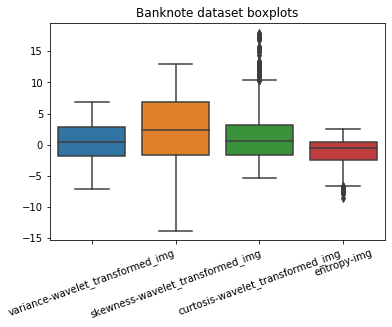

In [7]:
sns.boxplot(data=banknote_data.iloc[:, :-1])

plt.title("Banknote dataset boxplots")
plt.xticks(rotation = 20)
plt.show()

### Observations:
The attributes of the dataset seem to have a normal distribution with outliers for the last two attributes

In [8]:
# Divide data into features (X) and label (y)-

# 'X' contains attributes-
X = banknote_data.drop('class', axis = 1)

# 'y' contains labels-
y = banknote_data['class']

In [9]:
# Standardize certain features/attributes in dataset-
rb_scaler = RobustScaler()

# Standardize features (X) in dataset-
X_std = rb_scaler.fit_transform(X)

In [10]:
# Divide attributes & labels into training & testing sets-
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30)
print("\n\nDimensions of training and testing sets are:")
print("X_train = {0}, y_train = {1}, X_test = {2} & y_test = {3}\n\n".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))



Dimensions of training and testing sets are:
X_train = (960, 4), y_train = (960,), X_test = (412, 4) & y_test = (412,)




In [11]:
# Convert training and testing sets to floating types as numpy arrays-
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

y_train = np.asarray(y_train, dtype = np.float16)
y_test = np.asarray(y_test, dtype = np.float16)

In [14]:
def create_nn():
    """
    Function to create a
    Neural Network
    """
    model = Sequential()                                                    

    model.add(
        Dense(
            units = 4, activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            input_shape = (4,)
        )
    )

    model.add(
        Dense(
            units = 3, activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal()
        )
    )

    model.add(
        Dense(
            units = 1, activation = 'sigmoid'
        )
    )

    """
    # Compile the defined NN model above-
    model.compile(
        loss = 'binary_crossentropy',  # loss = 'categorical_crossentropy'
        optimizer = tf.keras.optimizers.Adam(lr = 0.001),
        metrics=['accuracy']
    )
    """

    return model



### First _fit()_ method with _EarlyStopping_ is used:

In [15]:
# Instantiate a model-
model = create_nn()

In [16]:
# Save weights for fair comparison-
model.save_weights("Random_Weights.h5", overwrite=True)

### _fit()_ method arguments:

1. _batch_size:_ Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of symbolic tensors, datasets, generators, or keras.utils.Sequence instances (since they generate batches).

1. _epochs:_ Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.

1. _shuffle:_ Boolean (whether to shuffle the training data before each epoch) or str (for 'batch'). 'batch' is a special option for dealing with the limitations of HDF5 data; __it shuffles in batch-sized chunks__. Has no effect when _steps_per_epoch_ is not None.

In [17]:
# Compile model-
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(lr = 0.001),
    metrics = ['accuracy'],
    shuffle = True
    )

In [18]:
# Define early stopping-
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3,
    min_delta = 0.001, mode = 'min'
)

In [19]:
# Train defined model-
history_orig = model.fit(
    x = X_train, y = y_train,
    batch_size = 32, epochs = 500,
    validation_data = (X_test, y_test),
    callbacks = [callback],
    verbose = 1
)


Train on 960 samples, validate on 412 samples
Epoch 1/500
960/960 [==============================] - 1s 920us/sample - loss: 0.8800 - accuracy: 0.3531 - val_loss: 0.8168 - val_accuracy: 0.3714
Epoch 2/500
960/960 [==============================] - 0s 85us/sample - loss: 0.8081 - accuracy: 0.3948 - val_loss: 0.7661 - val_accuracy: 0.4684
Epoch 3/500
960/960 [==============================] - 0s 94us/sample - loss: 0.7600 - accuracy: 0.4531 - val_loss: 0.7330 - val_accuracy: 0.4976
Epoch 4/500
960/960 [==============================] - 0s 83us/sample - loss: 0.7274 - accuracy: 0.4875 - val_loss: 0.7090 - val_accuracy: 0.5121
Epoch 5/500
960/960 [==============================] - 0s 92us/sample - loss: 0.7032 - accuracy: 0.5344 - val_loss: 0.6907 - val_accuracy: 0.5607
Epoch 6/500
960/960 [==============================] - 0s 106us/sample - loss: 0.6850 - accuracy: 0.5740 - val_loss: 0.6778 - val_accuracy: 0.5947
Epoch 7/500
960/960 [==============================] - 0s 94us/sample - loss

In [ ]:
history_orig.history['val_loss']

### Sanity Check: see whether _EarlyStopping_ is actually working:
Using _patience_ of 3 and _min_delta_ = 0.001 while monitoring the _validation loss_ ('val_loss')

In [21]:
# 'min_delta'-
md = 0.001

In [22]:
# Get the last three values-
x = history_orig.history['val_loss'][-3:]

In [23]:
print(x)

[0.022204587199878924, 0.021869326950710952, 0.021576166388045236]


In [24]:
# Compute absolute consecutive difference between each subsequent elements-
np.abs(np.diff(x, n = 1))

array([0.00033526, 0.00029316])

In [25]:
# Check whether absolute consecutive differences between each subsequent elements
# is greater than 'min_delta'-
np.abs(np.diff(x, n = 1)) > md

array([False, False])

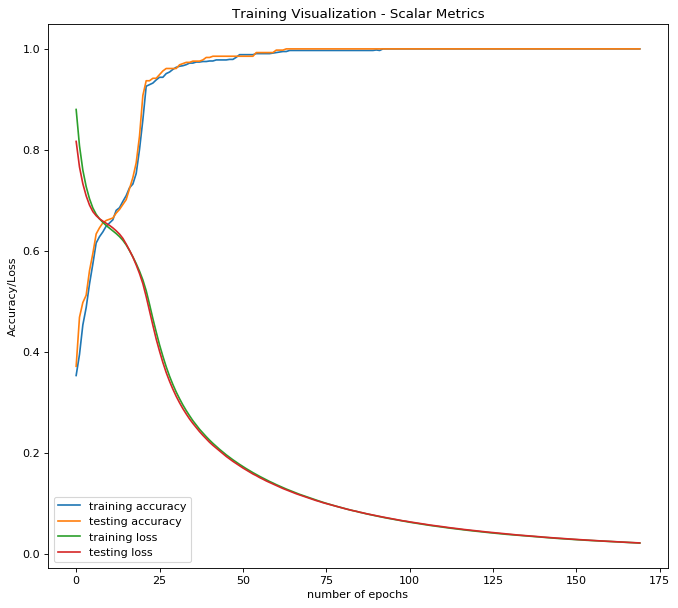

In [26]:
# Visualize training progress of neural network model-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['accuracy'], label = 'training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'testing accuracy')
plt.plot(history_orig.history['loss'], label = 'training loss')
plt.plot(history_orig.history['val_loss'], label = 'testing loss')

plt.title("Training Visualization - Scalar Metrics")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc = 'best')
plt.show()


### Now, use 'GradientTape' to train another instance of defined model-

In [27]:
# Create datasets to be used for GradientTape-

# Use tf.data to batch and shuffle the dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(32).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).shuffle(32).batch(32)


In [38]:
del model_gt

In [39]:
# Instantiate a model-
model_gt = create_nn()

In [40]:
# Restore random weights as used by the previous model for fair comparison-
model_gt.load_weights("Random_Weights.h5")

In [41]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [42]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

In [43]:
# Use tf.GradientTape to train the model-

@tf.function
def train_step(data, labels):
    """
    Function to perform one step of Gradient
    Descent optimization
    """

    with tf.GradientTape() as tape:
        predictions = model_gt(data)
        loss = loss_fn(labels, predictions)

    gradients = tape.gradient(loss, model_gt.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_gt.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

    

In [44]:
@tf.function
def test_step(data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model_gt(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [45]:
EPOCHS = 500

# User input-
minimum_delta = 0.001
patience = 3

patience_val = np.zeros(patience)

In [46]:
# Dictionary to hold scalar metrics-
history = {}

history['accuracy'] = np.zeros(EPOCHS)
history['val_accuracy'] = np.zeros(EPOCHS)
history['loss'] = np.zeros(EPOCHS)
history['val_loss'] = np.zeros(EPOCHS)

In [47]:
# To change all layers to have dtype float64 by default-
tf.keras.backend.set_floatx('float64')

### Logic behind manual _EarlyStopping_:
_check = np.diff(history['val_loss'][epoch - 3:epoch], n = 1) > minimum_delta_ checks whether the absolute value of the consecutive differences between the last 3 epoch's _validation loss_ is more than _minimum delta_

1. _Case - 1:_ If any of these absolute values of the consecutive differences is _greater than_ _min_delta_, then __keep training__

1. _Case - 2_: If all of these absolute values of the consecutive differences is _less than_ _min_delta_, then __Stop training__

In [48]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    for x_t, y_t in test_ds:
        test_step(x_t, y_t)

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

    history['accuracy'][epoch] = train_accuracy.result()
    history['loss'][epoch] = train_loss.result()
    history['val_loss'][epoch] = test_loss.result()
    history['val_accuracy'][epoch] = test_accuracy.result()

    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))

    if epoch > 2:
        # Computes absolute differences between 3 consecutive loss values-
        differences = np.abs(np.diff(history['val_loss'][epoch - 3:epoch], n = 1))
        
        # Checks whether the absolute differences is greater than 'minimum_delta'-
        check =  differences > minimum_delta
        
        # print('differences: {0}'.format(differences))
        
        # Count unique element with it's counts-
        # elem, count = np.unique(check, return_counts=True)
        # print('\nelem = {0}, count = {1}'.format(elem, count))
        
        if np.all(check == False):
        # if elem.all() == False and count == 2:
            print("\n\nEarlyStopping Evoked! Stopping training\n\n")
            break



Epoch 1, Loss: 0.8801, Accuracy: 35.3125, Test Loss: 0.8143, Test Accuracy: 36.847527
Epoch 2, Loss: 0.8075, Accuracy: 39.8958, Test Loss: 0.7646, Test Accuracy: 47.390110
Epoch 3, Loss: 0.7594, Accuracy: 44.8958, Test Loss: 0.7319, Test Accuracy: 49.965659
Epoch 4, Loss: 0.7267, Accuracy: 48.5417, Test Loss: 0.7080, Test Accuracy: 52.266484
Epoch 5, Loss: 0.7027, Accuracy: 53.9583, Test Loss: 0.6905, Test Accuracy: 54.910714
Epoch 6, Loss: 0.6850, Accuracy: 56.7708, Test Loss: 0.6780, Test Accuracy: 59.443681
Epoch 7, Loss: 0.6727, Accuracy: 61.0417, Test Loss: 0.6699, Test Accuracy: 63.495879
Epoch 8, Loss: 0.6638, Accuracy: 62.6042, Test Loss: 0.6639, Test Accuracy: 64.285714
Epoch 9, Loss: 0.6569, Accuracy: 63.9583, Test Loss: 0.6598, Test Accuracy: 65.041209
Epoch 10, Loss: 0.6510, Accuracy: 64.4792, Test Loss: 0.6556, Test Accuracy: 65.315934
Epoch 11, Loss: 0.6458, Accuracy: 65.3125, Test Loss: 0.6514, Test Accuracy: 66.037088
Epoch 12, Loss: 0.6408, Accuracy: 65.8333, Test Loss

### Sanity check:

In [50]:
history['val_loss'][104:107]

array([0.05881222, 0.05781347, 0.05680743])

In [51]:
np.abs(np.diff(history['val_loss'][104:107], n = 1)) > md

array([False,  True])

### Observations:
1.) Using GradientTape-
Epoch 107, Loss: 0.0560, Accuracy: 100.0000, Test Loss: 0.0568, Test Accuracy: 100.000000


2.) Using model.fit()-
Epoch 170/500
960/960 [==============================] - 0s 121us/sample - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 1.0000

### _GradientTape_:
One _epoch_ goes through all of the 960 samples or training data in training dataset. And also through all of the 412 testing data in testing dataset.

Sanity check is below-

In [53]:
# Count number of samples or training data points in training dataset-
c = 0

for x, y in train_ds:
    c += x.shape[0]

In [54]:
c

960

In [55]:
# Count number of samples or testing data points in testing dataset-
c = 0

for x, y in test_ds:
    c += x.shape[0]

In [56]:
c

412